<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Source" data-toc-modified-id="Data-Source-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Source</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Chiangmai-Geography" data-toc-modified-id="Chiangmai-Geography-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Chiangmai Geography</a></span></li><li><span><a href="#USA-AQI-vs-Thailand-AQI" data-toc-modified-id="USA-AQI-vs-Thailand-AQI-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>USA AQI vs Thailand AQI</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Correlation-Between-Pollutants" data-toc-modified-id="Correlation-Between-Pollutants-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Correlation Between Pollutants</a></span></li><li><span><a href="#Is-the-pollution-getting-worse?" data-toc-modified-id="Is-the-pollution-getting-worse?-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Is the pollution getting worse?</a></span></li><li><span><a href="#Compare-Weather" data-toc-modified-id="Compare-Weather-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Compare Weather</a></span></li><li><span><a href="#Effect-of-Logistic-Activities" data-toc-modified-id="Effect-of-Logistic-Activities-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Effect of Logistic Activities</a></span></li><li><span><a href="#Seasonal-Hotspot" data-toc-modified-id="Seasonal-Hotspot-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Seasonal Hotspot</a></span></li></ul></div>

# Data Source 
1. Berekely Earth 'http://berkeleyearth.lbl.gov/air-quality/maps/cities/Thailand/'
2. Screaped Air4Thai Data 'http://air4thai.pcd.go.th/webV2/history/'
3. CDC Data 'https://www.cmuccdc.org/download_json/'
4. Old Air4Thai data from Thailand EPA

# Imports 

In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.read_data import *
from src.gen_functions import *
import seaborn as sns
output_notebook()
# set font size 
plt.rcParams.update({'font.size': 16})

from datetime import timedelta

Loading BokehJS ...

In [173]:
# transition from acceptable to unhealthy for sensitive group and to unhealthy. 
transition_dict = { 'PM2.5': [0, 35.5, 55.4, 1e3],
                  'PM10': [0, 155, 254, 1e3],
                  'O3':[0, 70 , 85, 1e3],
                  'SO2':[0, 75, 185, 1e3],
                  'NO2': [0, 100, 360, 1e3],
                  'CO': [0, 6.4, 12.5, 1e3]}

gas_list = ['SO2', 'CO', 'NO2', 'O3', 'PM10', 'PM2.5']
gas_list.reverse()
len(gas_list)


def add_season(df,start_month='-10-01', end_month='-05-01'):
    # add winter season column 
    
    df['year'] = df.index.year 
    df['season'] = 'other'
    for year in df.year.unique():
        start_date = str(year)+ start_month
        end_date = str(year+1)+ end_month
        label = 'winter_'+str(year)
    
        df.loc[start_date:end_date,'season'] = label 
        
    return df

In [3]:
b_folder='../data/pm25/'
a4th_folder ='../data/air4thai_hourly/'
cm_folder ='../data/cm_proc/'
cdc_folder = '../data/cdc_data/'
aqm_folder = '../data/aqm_hourly2/'

In [4]:
# berekely data
b_data, city_info = read_b_data(b_folder+'Chiang_Mai.txt')
b_data = b_data.set_index('datetime')
city_info

{'Country': 'Thailand',
 'City': 'Chiang Mai',
 'City (ASCII)': 'Chiang Mai',
 'Region': 'Chiang Mai',
 'Region (ASCII)': 'Chiang Mai',
 'Population': '200952',
 'Latitude': '18.7904',
 'Longitude': '98.9847',
 'Time Zone': 'Asia/Bangkok'}

In [5]:
# load stations information for air4 Thai
station_info_file = aqm_folder + 'stations_locations.json'
with open(station_info_file, 'r',encoding="utf8") as f:
    station_info = json.load(f)
station_info = station_info['stations']

# find stations in Chiangmai and parase that files
cm_station_ids = []
cm_station_info = []
for i, stations in enumerate(station_info):
    if 'Chiang Mai' in stations['areaEN']:
        cm_station_ids.append(stations['stationID'])
        cm_station_info.append(stations)
print(cm_station_ids)

['35t', '36t', 'm9', 'o10', 'o20', 'o22']


In [6]:
# combine new and old air4Thai data 
gas_cols = ['CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5']
for station_id in cm_station_ids:
    try: 
        old_data = pd.read_csv(aqm_folder + 'process/'+station_id + '.csv')
    except:
        old_data = pd.DataFrame()
    else:
        old_data['datetime'] = pd.to_datetime(old_data['datetime'])
        old_data = old_data.set_index('datetime')
        # keep only the gass columns
        old_data = old_data[gas_cols]
    
    new_data = pd.read_csv(a4th_folder + station_id + '.csv',na_values='-').set_index('datetime')
    new_data.columns = [s.split(' (')[0] for s in new_data.columns]
    # keep only the gass columns
    new_data = new_data[gas_cols]
    # concatinate data and save
    data = pd.concat([old_data,new_data])
    filename = cm_folder+station_id + '.csv'
    print(filename)
    data.to_csv(filename)

../data/cm_proc/35t.csv
../data/cm_proc/36t.csv
../data/cm_proc/m9.csv
../data/cm_proc/o10.csv
../data/cm_proc/o20.csv
../data/cm_proc/o22.csv


In [132]:
# parse station informatoin
re = requests.get('https://www.cmuccdc.org/download?fbclid=IwAR0XaoY1G5BSwHcQejEdGD5piw3LSLK4HLlmy4ElzIEBCmVkH2W6T8mTIx8')
soup = BeautifulSoup(re.text)
results = soup.find_all('li', class_='mb-3')

# find chiangmai stations
for item in results:
    if 'เชียงใหม่' in item.text:
        cmu_soup = item
        break
cmu_dustboy_ids = []
for cmu_html in cmu_soup.find_all('a'):
    href = cmu_html['href']
    if 'json' in href:
        dustboy_id = href.split('/')[-1]
        cmu_dustboy_ids.append(dustboy_id)
        
print(cmu_dustboy_ids)
print(len(cmu_dustboy_ids))

['108', '12', '2', '11', '5', '103', '5267', '109', '5264', '2004', '5281', '1', '83', '84', '4008', '4009', '4010', '4011', '4012', '4003', '4004', '4005', '4006', '4007', '6003', '2006', '5263', '20', '106', '4015', '4016', '4002', '6', '5163', '22', '27', '29', '38', '14', '89', '15', '32', '25', '23', '5376', '17', '19', '37', '24', '30', '16', '31', '34', '26', '18', '13', '35', '80', '78', '77', '79', '81', '41', '92', '5374', '5373', '5249', '5262', '5379', '2005', '28', '33', '36', '3', '2002', '5268', '7', '82', '5265', '5266', '5270', '5269', '5248', '6002', '4026', '4027', '4']
87


87 stations at different locations

In [152]:
# cmucdc data 
with open(cdc_folder+'station_info.json', 'r') as f:
    cdc_stations = json.load(f)

cmucdc_stations = []
# search for station information
for station in cdc_stations:
    if station['dustboy_id'] in cmu_dustboy_ids:
        
        try:
            df = pd.read_csv(cdc_folder + station['dustboy_id'] + '.csv')
        except:
            pass
        else:
            # keep only good station with data 
            cmucdc_stations.append(station)
        
len(cmucdc_stations)

25

In [153]:
cmucdc_stations

[{'dustboy_id': '5373',
  'dustboy_uri': 'thapaegate2',
  'dustboy_name_th': 'ลานประตูท่าแพ  (2)',
  'dustboy_name_en': '',
  'dustboy_lat': '18.787726',
  'dustboy_lng': '98.993370',
  'dustboy_version': 'mini'},
 {'dustboy_id': '5374',
  'dustboy_uri': 'thapaegate1',
  'dustboy_name_th': 'ลานประตูท่าแพ  (1)',
  'dustboy_name_en': '',
  'dustboy_lat': '18.787716',
  'dustboy_lng': '98.993563',
  'dustboy_version': 'mini'},
 {'dustboy_id': '5262',
  'dustboy_uri': 'N-112',
  'dustboy_name_th': 'สนามกีฬากลาง มหาวิทยาลัยเชียงใหม่',
  'dustboy_name_en': 'The Main Stadium, Chiang Mai University',
  'dustboy_lat': '18.797338',
  'dustboy_lng': '98.956578',
  'dustboy_version': 'mini'},
 {'dustboy_id': '5268',
  'dustboy_uri': 'N-118',
  'dustboy_name_th': 'สำนักบริการวิชาการ  มหาวิทยาลัยเชียงใหม่ ',
  'dustboy_name_en': 'University Academic  Service Center (UNISERV), Chiang Mai University',
  'dustboy_lat': '18.794057',
  'dustboy_lng': '98.966521',
  'dustboy_version': 'mini'},
 {'dustboy_

# Chiangmai Geography

In [2]:
from mpl_toolkits.basemap import Basemap
from bokeh.tile_providers import get_provider, Vendors

In [4]:
city_info = {'Country': 'Thailand',
 'City': 'Chiang Mai',
 'City (ASCII)': 'Chiang Mai',
 'Region': 'Chiang Mai',
 'Region (ASCII)': 'Chiang Mai',
 'Population': '200952',
 'Latitude': '18.7904',
 'Longitude': '98.9847',
 'Time Zone': 'Asia/Bangkok'}

In [308]:
aqm_station_coor = []
for station in cm_station_info[:2]:
    lat = merc_y(station['lat'])
    long = merc_x(station['long'])
    aqm_station_coor.append([lat, long])
aqm_station_coor = np.array(aqm_station_coor)

cmu_station_coor = []
for station in cmucdc_stations:
    lat = merc_y(station['dustboy_lat'])
    long = merc_x(station['dustboy_lng'])
    cmu_station_coor.append([lat, long])
cmu_station_coor = np.array(cmu_station_coor)


In [239]:
plant1 = [18.291836, 99.747635, 'coal']
plant2 = [19.199594, 97.981650, 'diesel']
plant3 = [18.188042, 97.934958, 'diesel']
plant4 = [16.629450, 99.870301, 'natural gas']

plant_list = [plant1[:2], plant2[:2], plant3[:2], plant4[:2]]
plant_list = [plant1, plant2, plant3, plant4]

plant_list = np.vstack(plant_list)
plant_list[:,1]

array(['99.747635', '97.98165', '97.934958', '99.870301'], dtype='<U32')

In [285]:
x = merc_x(city_info['Longitude'])
y = merc_y(city_info['Latitude'])
stepx = 2E5
stepy = stepx

industrial_loc = [18.595537, 99.044438]
ind_x = merc_x(industrial_loc[1])
ind_y = merc_y(industrial_loc[0])

In [337]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-stepx,x+1.2*stepx), y_range=(y-stepy*0.5, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'Power Plants and Industrical Site')
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))


new_x = merc_x(plant_list[:,1].astype(float))
new_y = [merc_y(y) for y in  plant_list[:,0]]
p.scatter(new_x,new_y,color='red',line_color='black',size=10, legend_label='power plants')

p.circle(ind_x,ind_y,color='blue',line_color='black',size=10, legend_label='industrial complex')

#p.scatter(aqm_station_coor[:,1],aqm_station_coor[:,0],color='magenta',size=10, legend_label='EPA stations w history')
p.circle(x,y,color='green',line_color='black',size=10, legend_label='Berkeley Earth Station')

#p.scatter(cmu_station_coor[:,1],cmu_station_coor[:,0],color='yellow',size=10, legend_label='CMU stations')


show(p)

In [336]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-stepx*0.9,x+0.9*stepx), y_range=(y-stepy*0.01, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'Station Information')
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

p.scatter(cmu_station_coor[:,1],cmu_station_coor[:,0],color='yellow',line_color='black',size=10, legend_label='CMU stations')

new_x = merc_x(plant_list[:,1].astype(float))
new_y = [merc_y(y) for y in  plant_list[:,0]]
p.scatter(new_x,new_y,color='red',line_color='black',size=10, legend_label='power plants')

p.circle(ind_x,ind_y,color='blue',line_color='black',size=10, legend_label='industrial complex')

p.scatter(aqm_station_coor[:,1],aqm_station_coor[:,0],color='magenta',line_color='black',size=10, legend_label='EPA stations w history')
p.circle(x,y,color='green',size=8,line_color='black', legend_label='Berkeley Earth Coordinate')

p.legend.location = "bottom_right"

show(p)

In [338]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-stepx*0.1,x+0.1*stepx), y_range=(y-stepy*0.01, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'Station Information(downtown)')
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

p.scatter(cmu_station_coor[:,1],cmu_station_coor[:,0],color='yellow', line_color='black',size=10, legend_label='CMU stations')

new_x = merc_x(plant_list[:,1].astype(float))
new_y = [merc_y(y) for y in  plant_list[:,0]]
#p.scatter(new_x,new_y,color='red',size=10, legend_label='power plants')

#p.circle(ind_x,ind_y,color='blue',size=10, legend_label='industrial complex')

p.scatter(aqm_station_coor[:,1],aqm_station_coor[:,0],color='magenta',line_color='black',size=10, legend_label='EPA stations w history')
p.circle(x,y,color='green',size=8,line_color='black', legend_label='Berkeley Earth Coordinate')

p.legend.location = "bottom_right"

show(p)

# USA AQI vs Thailand AQI


AQI conversion: https://aqicn.org/calculator, https://airnow.gov/index.cfm?action=airnow.calculator, 
http://air4thai.pcd.go.th/webV2/aqi_info.php

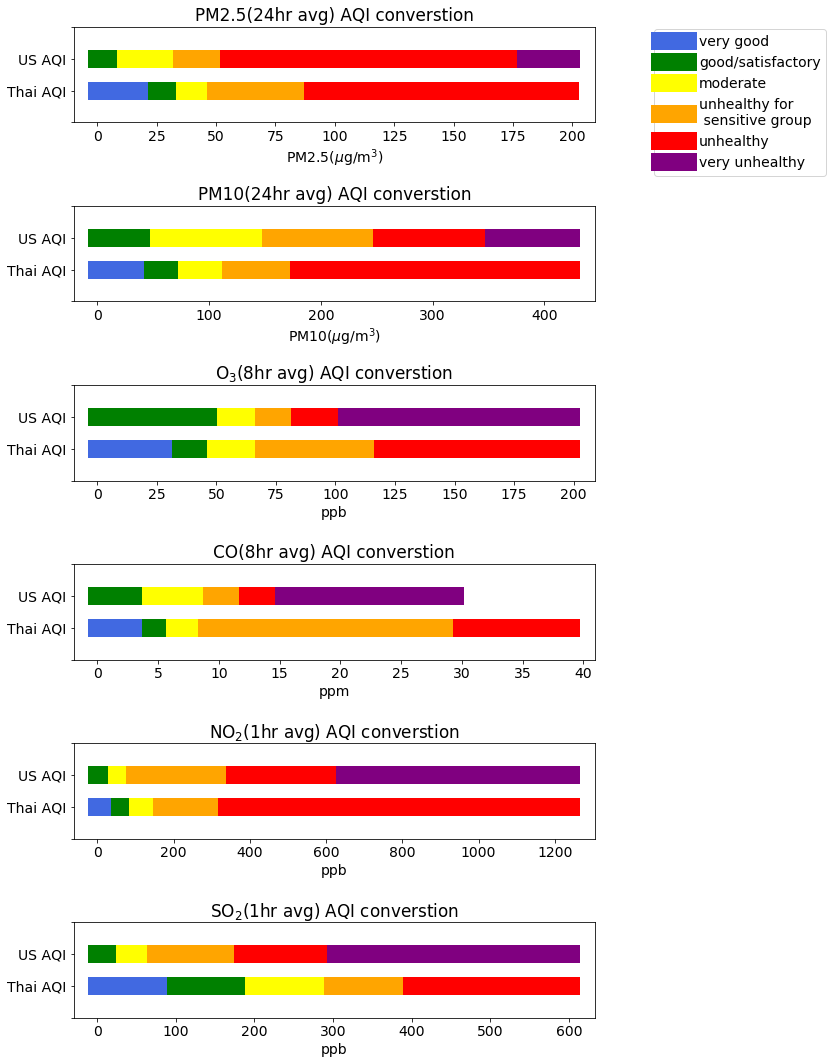

In [434]:
plt.rcParams.update({'font.size': 14})
_, ax = plt.subplots(6,1, figsize=(12, 15))

ax[0].set_title('PM2.5(24hr avg) AQI converstion')
# Thailand 
ax[0].plot(np.arange(0, 25), np.zeros(len(np.arange(0, 25))),
        c='royalblue', marker='_', lw=18, label='very good')
# us
ax[0].plot(np.arange(0, 12), np.ones(len(np.arange(0, 12))),
        c='green', marker='_', lw=18, label='good/satisfactory')
ax[0].plot(np.arange(12, 35.5), np.ones(len(np.arange(12, 35.5))),
        c='yellow', marker='_', lw=18, label='moderate')
ax[0].plot(np.arange(35.5, 55.5), np.ones(len(np.arange(35.5, 55.5))),
        c='orange', marker='_', lw=18, label='unhealthy for \n sensitive group')
ax[0].plot(np.arange(55.5, 180.5), np.ones(len(np.arange(55.5, 180.5))),
        c='red', marker='_', lw=18, label='unhealthy')
ax[0].plot(np.arange(180.5, 200.0), np.ones(len(np.arange(180.5, 200))),
        c='purple', marker='_', lw=18, label='very unhealthy')

# the rest of Thailand
ax[0].plot(np.arange(25, 37), np.zeros(
    len(np.arange(25, 37))), c='green', marker='_', lw=18)
ax[0].plot(np.arange(37, 50), np.zeros(len(np.arange(37, 50))),
        c='yellow', marker='_', lw=18)
ax[0].plot(np.arange(50, 91), np.zeros(len(np.arange(50, 91))),
        c='orange', marker='_', lw=18)
ax[0].plot(np.arange(91, 200), np.zeros(
    len(np.arange(91, 200))), c='red', marker='_', lw=18)
ax[0].set_xlabel('PM2.5($\mu$g/m$^3$)')

#-----------------------PM10---------------------------

ax[1].set_title('PM10(24hr avg) AQI converstion')

#-------------us
ax[1].plot(np.arange(0, 55), np.ones(len(np.arange(0, 55))),
        c='green', marker='_', lw=18, label='good/satisfactory')
ax[1].plot(np.arange(55, 155), np.ones(len(np.arange(55, 155))),
        c='yellow', marker='_', lw=18, label='moderate')
ax[1].plot(np.arange(155, 255), np.ones(len(np.arange(155, 255))),
        c='orange', marker='_', lw=18, label='unhealthy for \n sensitive group')
ax[1].plot(np.arange(255, 355), np.ones(len(np.arange(255, 355))),
        c='red', marker='_', lw=18, label='unhealthy')
ax[1].plot(np.arange(355, 425), np.ones(len(np.arange(355, 425))),
        c='purple', marker='_', lw=18, label='very unhealthy')

#-------------Thailand -------------------
ax[1].plot(np.arange(0, 50), np.zeros(len(np.arange(0, 50))),
        c='royalblue', marker='_', lw=18, label='very good')
ax[1].plot(np.arange(50, 80), np.zeros(
    len(np.arange(50, 80))), c='green', marker='_', lw=18)
ax[1].plot(np.arange(80, 120), np.zeros(len(np.arange(80, 120))),
        c='yellow', marker='_', lw=18)
ax[1].plot(np.arange(120, 180), np.zeros(len(np.arange(120, 180))),
        c='orange', marker='_', lw=18)
ax[1].plot(np.arange(180, 425), np.zeros(
    len(np.arange(180, 425))), c='red', marker='_', lw=18)
ax[1].set_xlabel('PM10($\mu$g/m$^3$)')

#-----------------------O3---------------------------

ax[2].set_title('O$_3$(8hr avg) AQI converstion')


ax[2].plot(np.arange(0, 54), np.ones(len(np.arange(0, 54))),
        c='green', marker='_', lw=18, label='good/satisfactory')
ax[2].plot(np.arange(54, 70), np.ones(len(np.arange(54,  70))),
        c='yellow', marker='_', lw=18, label='moderate')
ax[2].plot(np.arange(70, 85), np.ones(len(np.arange(70, 85))),
        c='orange', marker='_', lw=18, label='unhealthy for \n sensitive group')
ax[2].plot(np.arange(85, 105), np.ones(len(np.arange(85, 105))),
        c='red', marker='_', lw=18, label='unhealthy')
ax[2].plot(np.arange(105, 200), np.ones(len(np.arange(105, 200))),
        c='purple', marker='_', lw=18, label='very unhealthy')

ax[2].plot(np.arange(0, 35), np.zeros(len(np.arange(0, 35))),
        c='royalblue', marker='_', lw=18, label='very good')
ax[2].plot(np.arange(35, 50), np.zeros(
    len(np.arange(35, 50))), c='green', marker='_', lw=18)
ax[2].plot(np.arange(50, 70), np.zeros(len(np.arange(50, 70))),
        c='yellow', marker='_', lw=18)
ax[2].plot(np.arange(70, 120), np.zeros(len(np.arange(70, 120))),
        c='orange', marker='_', lw=18)
ax[2].plot(np.arange(120, 200), np.zeros(
    len(np.arange(120, 200))), c='red', marker='_', lw=18)
ax[2].set_xlabel('ppb')

#-----------------------CO---------------------------

ax[3].set_title('CO(8hr avg) AQI converstion')


ax[3].plot(np.arange(0, 4.4), np.ones(len(np.arange(0, 4.4))),
        c='green', marker='_', lw=18, label='good/satisfactory')
ax[3].plot(np.arange(4.4, 9.4), np.ones(len(np.arange(4.4,  9.4))),
        c='yellow', marker='_', lw=18, label='moderate')
ax[3].plot(np.arange(9.4, 12.5), np.ones(len(np.arange(9.4, 12.5))),
        c='orange', marker='_', lw=18, label='unhealthy for \n sensitive group')
ax[3].plot(np.arange(12.4, 15.4), np.ones(len(np.arange(12.4, 15.4))),
        c='red', marker='_', lw=18, label='unhealthy')
ax[3].plot(np.arange(15.4, 30.4), np.ones(len(np.arange(15.4, 30.4))),
        c='purple', marker='_', lw=18, label='very unhealthy')

ax[3].plot(np.arange(0, 4.4), np.zeros(len(np.arange(0, 4.4))),
        c='royalblue', marker='_', lw=18, label='very good')
ax[3].plot(np.arange(4.4, 6.4), np.zeros(
    len(np.arange(4.4, 6.4))), c='green', marker='_', lw=18)
ax[3].plot(np.arange(6.4, 9.0), np.zeros(len(np.arange(6.4, 9.0))),
        c='yellow', marker='_', lw=18)
ax[3].plot(np.arange(9.0, 30), np.zeros(len(np.arange(9.0, 30))),
        c='orange', marker='_', lw=18)
ax[3].plot(np.arange(30, 40), np.zeros(
    len(np.arange(30, 40))), c='red', marker='_', lw=18)
ax[3].set_xlabel('ppm')

#-----------------------NO2---------------------------

ax[4].set_title('NO$_2$(1hr avg) AQI converstion')

ax[4].plot(np.arange(0, 53), np.ones(len(np.arange(0, 53))),
        c='green', marker='_', lw=18, label='good/satisfactory')
ax[4].plot(np.arange(53, 100), np.ones(len(np.arange(53,  100))),
        c='yellow', marker='_', lw=18, label='moderate')
ax[4].plot(np.arange(100, 360), np.ones(len(np.arange(100, 360))),
        c='orange', marker='_', lw=18, label='unhealthy for \n sensitive group')
ax[4].plot(np.arange(360, 649), np.ones(len(np.arange(360, 649))),
        c='red', marker='_', lw=18, label='unhealthy')
ax[4].plot(np.arange(649, 1244), np.ones(len(np.arange(649, 1244))),
        c='purple', marker='_', lw=18, label='very unhealthy')


# ---- Thailand ----------------
ax[4].plot(np.arange(0, 60), np.zeros(len(np.arange(0, 60))),
        c='royalblue', marker='_', lw=18, label='very good')
ax[4].plot(np.arange(60, 106), np.zeros(
    len(np.arange(60, 106))), c='green', marker='_', lw=18)
ax[4].plot(np.arange(106, 170), np.zeros(len(np.arange(106, 170))),
        c='yellow', marker='_', lw=18)
ax[4].plot(np.arange(170, 340), np.zeros(len(np.arange(170, 340))),
        c='orange', marker='_', lw=18)
ax[4].plot(np.arange(340, 1244), np.zeros(
    len(np.arange(340, 1244))), c='red', marker='_', lw=18)
ax[4].set_xlabel('ppb')

#-----------------------SO2---------------------------

ax[5].set_title('SO$_2$(1hr avg) AQI converstion')



ax[5].plot(np.arange(0, 35), np.ones(len(np.arange(0, 35))),
        c='green', marker='_', lw=18, label='good/satisfactory')
ax[5].plot(np.arange(35, 75), np.ones(len(np.arange(35,  75))),
        c='yellow', marker='_', lw=18, label='moderate')
ax[5].plot(np.arange(75, 185), np.ones(len(np.arange(75, 185))),
        c='orange', marker='_', lw=18, label='unhealthy for \n sensitive group')
ax[5].plot(np.arange(185, 304), np.ones(len(np.arange(185, 304))),
        c='red', marker='_', lw=18, label='unhealthy')
ax[5].plot(np.arange(304, 604), np.ones(len(np.arange(304, 604))),
        c='purple', marker='_', lw=18, label='very unhealthy')

ax[5].plot(np.arange(0, 100), np.zeros(len(np.arange(0, 100))),
        c='royalblue', marker='_', lw=18, label='very good')
ax[5].plot(np.arange(100, 200), np.zeros(
    len(np.arange(100, 200))), c='green', marker='_', lw=18)
ax[5].plot(np.arange(200, 300), np.zeros(len(np.arange(200, 300))),
        c='yellow', marker='_', lw=18)
ax[5].plot(np.arange(300, 400), np.zeros(len(np.arange(300, 400))),
        c='orange', marker='_', lw=18)
ax[5].plot(np.arange(400, 604), np.zeros(
    len(np.arange(400, 604))), c='red', marker='_', lw=18)
ax[5].set_xlabel('ppb')

ax[0].legend(bbox_to_anchor=(1.1, 1.05))


labels = [item.get_text() for item in ax[0].get_yticklabels()]
labels[1] = 'Thai AQI'
labels[2] = 'US AQI'
#labels[3] = 'My Level'

for a in ax:
    a.set_ylim([-1, 2])
    a.set_yticklabels(labels)


plt.tight_layout()

AQI convertion is comparable for for PM2.5, PM10 and NO2. AQI for CO and SO2 are under estimated. 

# Data 


In [198]:
# berekely data
b_data, city_info = read_b_data(b_folder+'Chiang_Mai.txt')
b_data = b_data.set_index('datetime')
print(b_data.columns)
print(b_data.shape)
aqm1 = pd.read_csv(cm_folder + '35t.csv').set_index('datetime').dropna(how='all')
aqm1.index = pd.to_datetime(aqm1.index)
aqm2 = pd.read_csv(cm_folder + '36t.csv').set_index('datetime').dropna(how='all')
aqm2.index = pd.to_datetime(aqm2.index)
print(aqm2.columns)

Index(['PM2.5'], dtype='object')
(31847, 1)
Index(['CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5'], dtype='object')


In [9]:
# take daily average
b_day = b_data.resample('d').mean()
aqm1_day = aqm1.resample('d').mean()
aqm2_day = aqm2.resample('d').mean()

Text(0.5, 1.0, 'Compare Different Stations and Data Source')

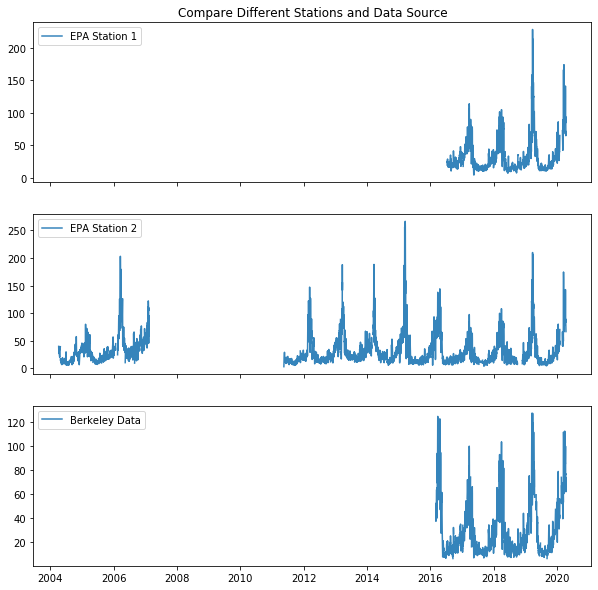

In [391]:
_, ax = plt.subplots(3,1, figsize=(10,10),sharex=True)
ax[0].plot(aqm1_day['PM2.5'],label='EPA Station 1',alpha=0.9)
ax[1].plot(aqm2_day['PM2.5'],label='EPA Station 2',alpha=0.9)
ax[2].plot(b_day['PM2.5'],label='Berkeley Data',alpha=0.9)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
ax[0].set_title('Compare Different Stations and Data Source')

Text(0.5, 1.0, 'Compare Different Stations and Data Source')

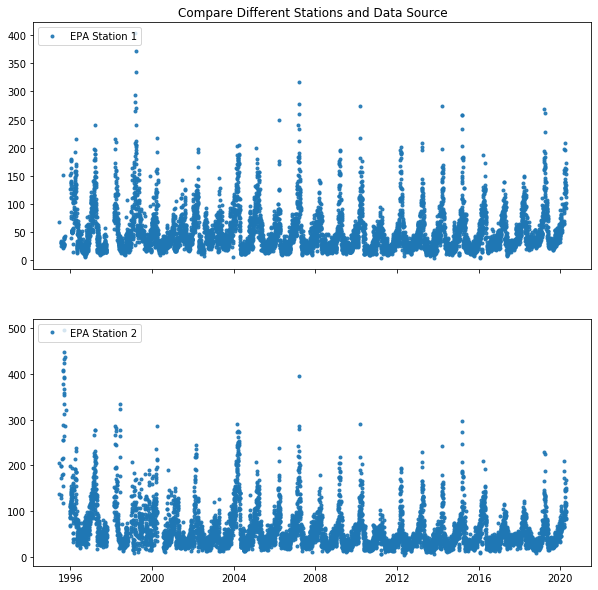

In [400]:
_, ax = plt.subplots(2,1, figsize=(10,10),sharex=True)
ax[0].plot(aqm1_day['PM10'],label='EPA Station 1',alpha=0.9, marker='.',linewidth=0)
ax[1].plot(aqm2_day['PM10'],label='EPA Station 2',alpha=0.9, marker='.',linewidth=0)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[0].set_title('Compare Different Stations and Data Source')

Text(0.5, 1.0, 'Compare Different Stations and Data Source')

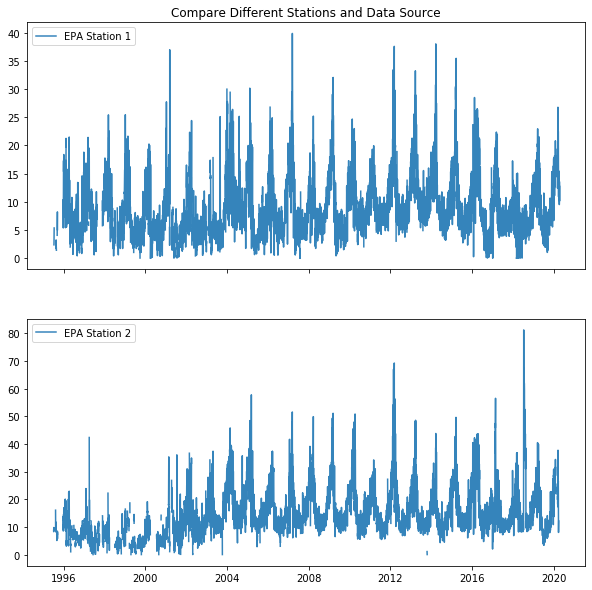

In [393]:
_, ax = plt.subplots(2,1, figsize=(10,10),sharex=True)
ax[0].plot(aqm1_day['NO2'],label='EPA Station 1',alpha=0.9)
ax[1].plot(aqm2_day['NO2'],label='EPA Station 2',alpha=0.9)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[0].set_title('Compare Different Stations and Data Source')

Text(0.5, 1.0, 'Compare Different Stations and Data Source')

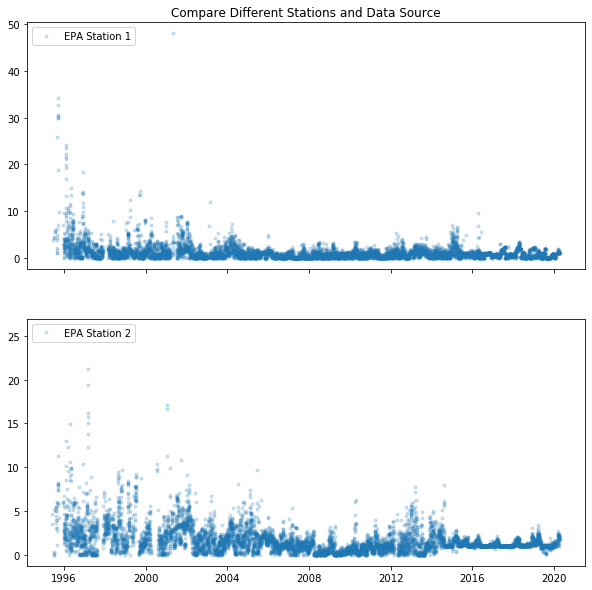

In [401]:
_, ax = plt.subplots(2,1, figsize=(10,10),sharex=True)
ax[0].plot(aqm1_day['SO2'],label='EPA Station 1',alpha=0.2, marker='.',linewidth=0)
ax[1].plot(aqm2_day['SO2'],label='EPA Station 2',alpha=0.2, marker='.',linewidth=0)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[0].set_title('Compare Different Stations and Data Source')

Text(0.5, 1.0, 'Compare Different Stations and Data Source')

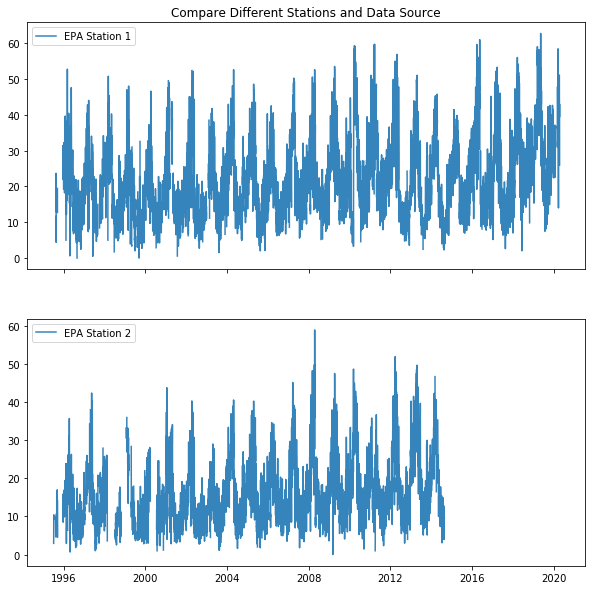

In [395]:
_, ax = plt.subplots(2,1, figsize=(10,10),sharex=True)
ax[0].plot(aqm1_day['O3'],label='EPA Station 1',alpha=0.9)
ax[1].plot(aqm2_day['O3'],label='EPA Station 2',alpha=0.9)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[0].set_title('Compare Different Stations and Data Source')

In [172]:
# transition from acceptable to unhealthy for sensitive group and to unhealthy. 
transition_dict = { 'PM2.5': [0, 35.5, 55.4, 1e3],
                  'PM10': [0, 155, 254, 1e3],
                  'O3':[0, 70 , 85, 1e3],
                  'SO2':[0, 75, 185, 1e3],
                  'NO2': [0, 100, 360, 1e3],
                  'CO': [0, 6.4, 12.5, 1e3]}

gas_list = ['SO2', 'CO', 'NO2', 'O3', 'PM10', 'PM2.5']
gas_list.reverse()
len(gas_list)

6

In [11]:
col = gas_list[-1]
data = aqm2_day[[col]].dropna()
xmin = data[data.index > '2010'].index.min()

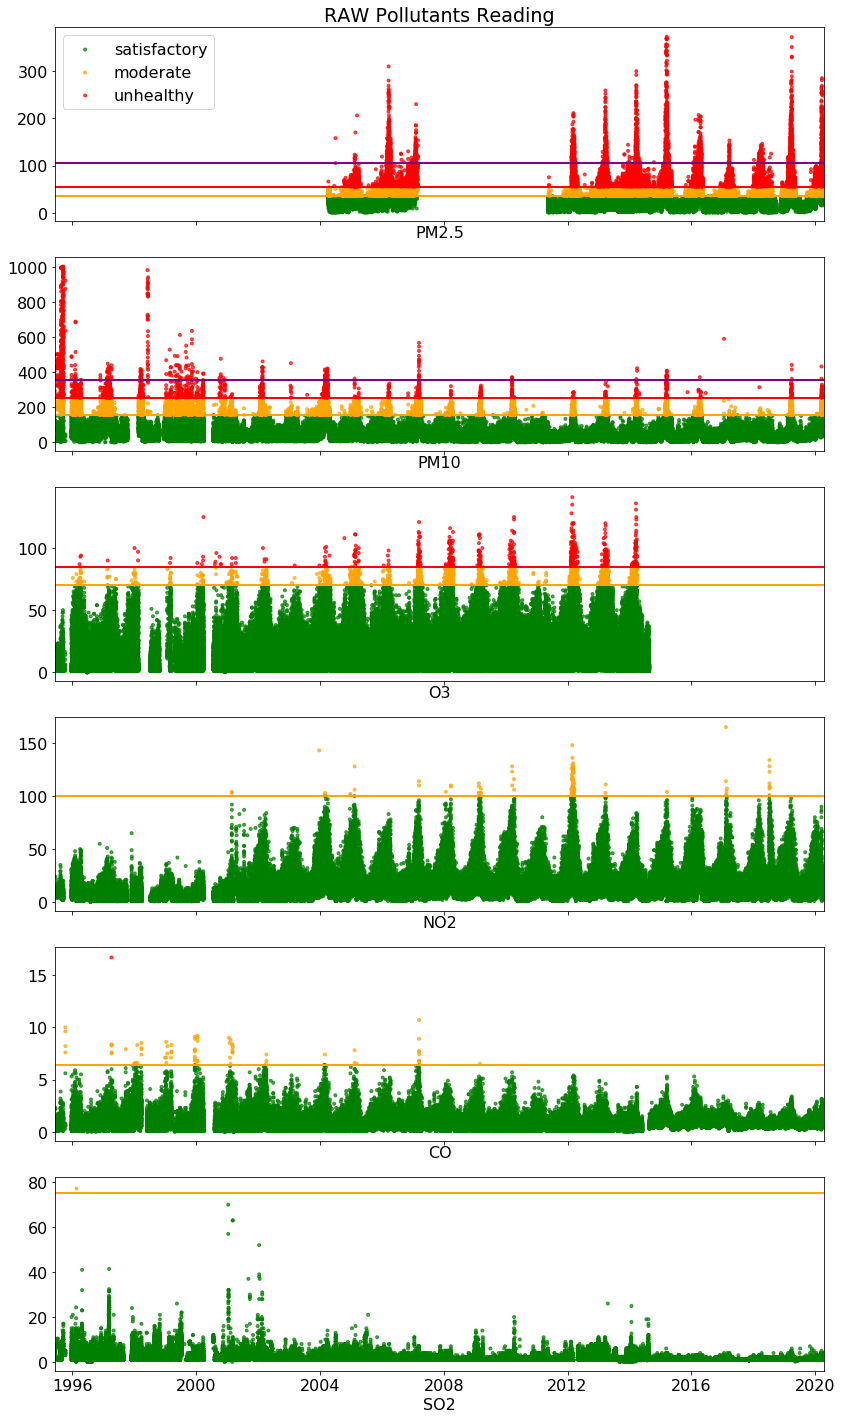

In [401]:
color_labels = ['green', 'orange', 'red']
level_names = ['satisfactory', 'moderate', 'unhealthy']

_, ax = plt.subplots(6, 1, figsize=(12, 20),sharex=True)


for i, _ in enumerate(ax):
    col = gas_list[i]
    data = aqm2[[col]].dropna()
    data['color'] = pd.cut(
        data[col], bins=transition_dict[col], labels=color_labels)

    for color, legend in zip(color_labels, level_names):
        temp = data[data['color'] == color]
        # plot the data for each pollution level
        ax[i].scatter(temp.index, temp[col],
                  c=temp['color'], marker='.', label=legend,alpha=0.7)
        ax[i].set_xlabel(col)
        ax[i].axhline(transition_dict[col][1],color='orange')
        if i in [0,1,2]:
            ax[i].axhline(transition_dict[col][2],color='red')
        if i == 0:
            ax[i].axhline(105, color='purple')
        if i == 1:
            ax[i].axhline(355, color='purple')
    
ax[0].legend(loc='upper left')
ax[0].set_xlim([data.index.min(), data.index.max()])
ax[0].set_title('RAW Pollutants Reading')

plt.tight_layout()

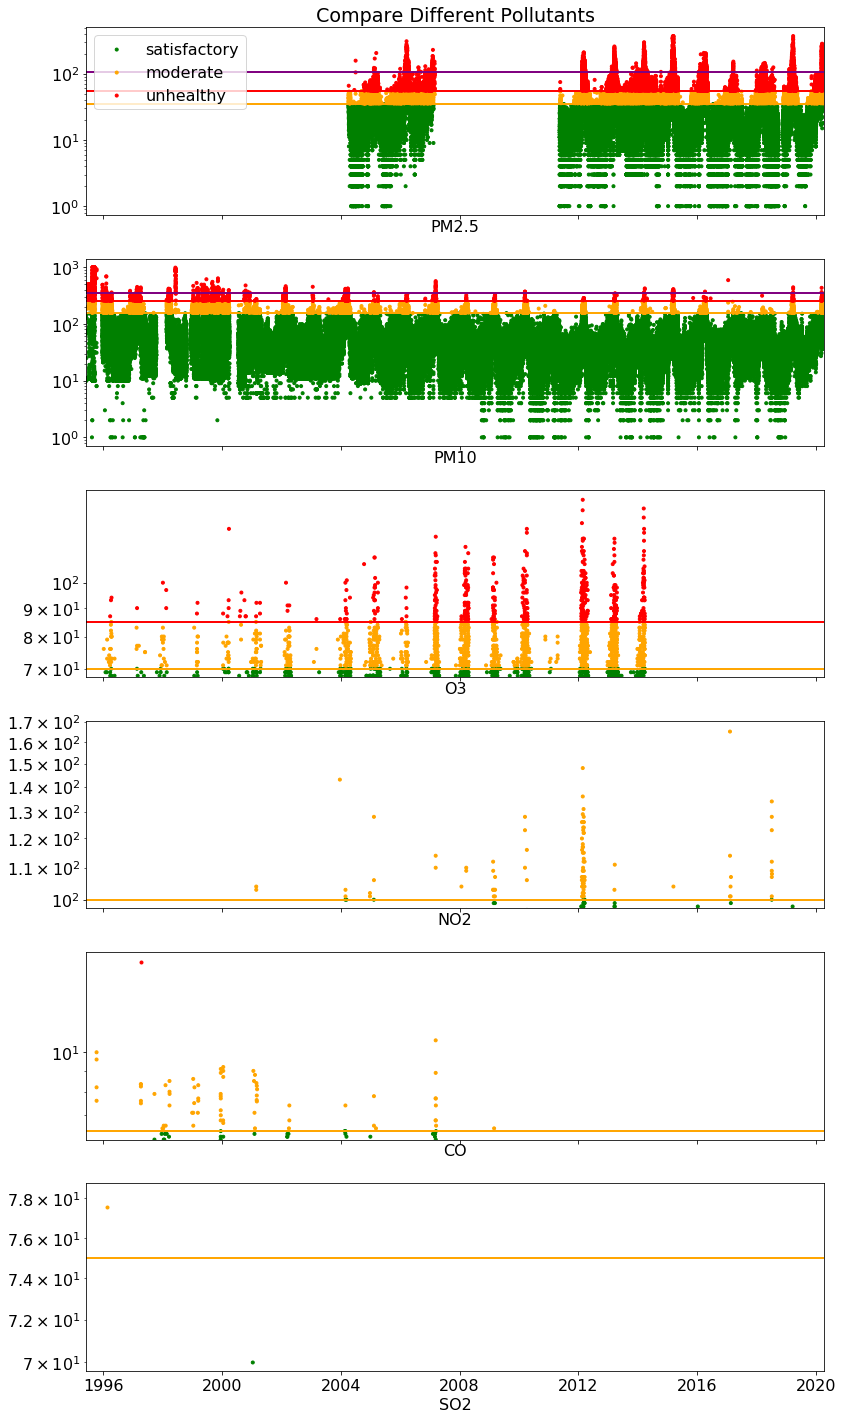

In [30]:
color_labels = ['green', 'orange', 'red']
level_names = ['satisfactory', 'moderate', 'unhealthy']

_, ax = plt.subplots(6, 1, figsize=(12, 20),sharex=True)


for i, _ in enumerate(ax):
    col = gas_list[i]
    data = aqm2[[col]].dropna()
    data['color'] = pd.cut(
        data[col], bins=transition_dict[col], labels=color_labels)

    for color, legend in zip(color_labels, level_names):
        temp = data[data['color'] == color]
        # plot the data for each pollution level
        ax[i].scatter(temp.index, temp[col],
                  c=temp['color'], marker='.', label=legend)
        ax[i].set_xlabel(col)
        ax[i].axhline(transition_dict[col][1],color='orange')
        if i in [0,1,2]:
            ax[i].axhline(transition_dict[col][2],color='red')
        if i == 0:
            ax[i].axhline(105, color='purple')
        if i == 1:
            ax[i].axhline(355, color='purple')
    ax[i].set_yscale('log')
    
ax[0].legend(loc='upper left')
ax[0].set_xlim([data.index.min(), data.index.max()])
ax[0].set_title('Compare Different Pollutants')

plt.tight_layout()

Start monitor PM2.5 in 2010 and the level has been high since start monitoring. The early data seems noisy and unreal.
PM10 are highly correlated with PM2.5, with level exceed unhealthy limit in every winter (purple line). Except for SO2, other pollutants also have seasonal pattern. O3 is the third AQI rank. PM2.5 are dominance source of high AQI, but PM10, and O3 in unhealthy range during winter also. 

Q: in the year with high PM2.5 or PM10 are other polluants higher? In another word, we want to learn the degree of correlation between all pollutants, to see if they are from the same sources. Let's look at the cross correlation matrix.

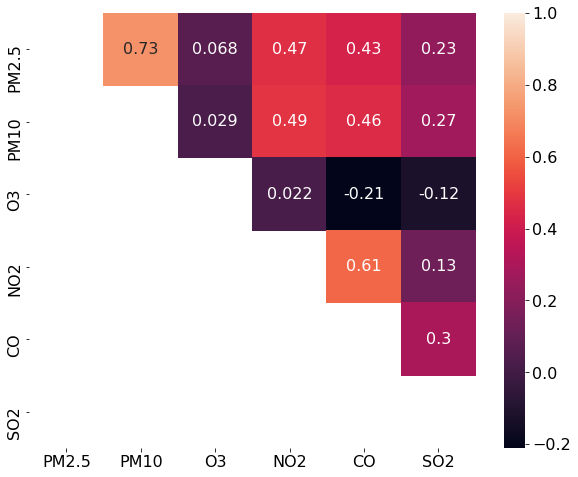

In [102]:
plt.figure(figsize=(10,8))
mask = np.tril(aqm2[gas_list].corr())
# use spearman rank correlation 
sns.heatmap(aqm2[gas_list].corr(method='spearman'), annot=True,mask=mask)

PM2.5 and PM10 has high correlation as expect. Surprisingly, there are low correlation between SO2 and both particle pollutions (PM2.5 and PM10). 

Let's look at lag correlation coefficient. Lag correlation is correlation of one data with respect to another data shifted by some time.

In [40]:
from scipy.stats import spearmanr

In [75]:
def find_lag_corr(df,col_list, cor_fun, lag_range):
    # find maximum lag correlation value and lag value from two columns in the col_list 
    
    # select the data
    temp = df[col_list].dropna()
    data1 = temp[col_list[0]]
    data2 = temp[col_list[1]]
    
    max_corr = 0
    max_lag = 0
    for lag_value in np.arange(-lag_range,lag_range):
        data2 = data2.shift(lag_value)
        temp = pd.concat([data1,data2],axis=1,ignore_index=True).dropna()
        coeff, _ = cor_fun(temp.iloc[:,0],temp.iloc[:,1])
        if max_corr < coeff:
            max_corr = coeff
            max_lag = lag_value
    return max_corr, max_lag

In [78]:
print(find_lag_corr(aqm2,col_list=['PM2.5','O3'],cor_fun=spearmanr, lag_range=48))
print(find_lag_corr(aqm2,col_list=['O3','PM2.5'],cor_fun=spearmanr, lag_range=48))

print(find_lag_corr(aqm2,col_list=['PM10','O3'],cor_fun=spearmanr, lag_range=48))
print(find_lag_corr(aqm2,col_list=['O3','PM10'],cor_fun=spearmanr, lag_range=48))

(0.20210265717366005, -32)
(0.12126767770887713, 47)
(0.18541595201948413, 41)
(0.1489895389136357, 46)


In [77]:
print(find_lag_corr(aqm2_day,col_list=['PM2.5','O3'],cor_fun=spearmanr, lag_range=7))
print(find_lag_corr(aqm2_day,col_list=['O3','PM2.5'],cor_fun=spearmanr, lag_range=7))

print(find_lag_corr(aqm2_day,col_list=['PM10','O3'],cor_fun=spearmanr, lag_range=7))
print(find_lag_corr(aqm2_day,col_list=['O3','PM10'],cor_fun=spearmanr, lag_range=7))

(0.4964119553900598, -4)
(0.4213757717471105, 6)
(0.379021023156442, 1)
(0.2780341952088922, 6)


Text(0.5, 1, 'correlation of monthly average value')

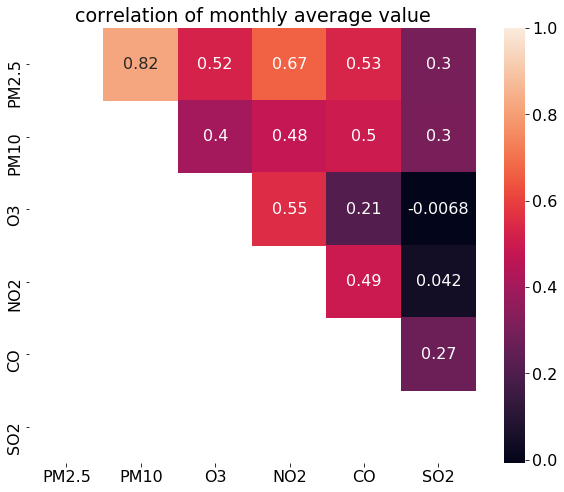

In [86]:
plt.figure(figsize=(10,8))
temp = aqm2.resample('d').mean()
mask = np.tril(temp[gas_list].corr())
# use spearman rank correlation 
sns.heatmap(temp[gas_list].corr(method='spearman'), annot=True,mask=mask)
plt.title('correlation of monthly average value')

Text(0.5, 1, 'correlation of monthly average value')

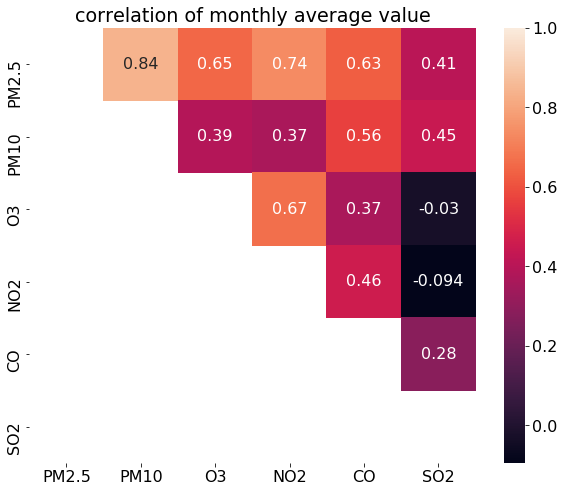

In [85]:
plt.figure(figsize=(10,8))
temp = aqm2.resample('m').mean()
mask = np.tril(temp[gas_list].corr())
# use spearman rank correlation 
sns.heatmap(temp[gas_list].corr(method='spearman'), annot=True,mask=mask)
plt.title('correlation of monthly average value')

In [470]:
# Severity over time

# Correlation Between Pollutants

In [200]:
# keep only the data after the satallite data which is 200-11-11 13 am
aqm2_01 = aqm2[aqm2.index>='2000-11-01 00:00:00'].copy()
aqm2_01.tail()

,CO,O3,NO2,SO2,PM10,PM2.5
datetime,,,,,,
2020-04-24 08:00:00,0.71,NaN,NaN,2.0,67.0,34.0
2020-04-24 09:00:00,0.67,NaN,NaN,2.0,74.0,33.0
2020-04-24 10:00:00,0.66,NaN,NaN,2.0,68.0,39.0
2020-04-24 11:00:00,0.64,NaN,NaN,1.0,71.0,50.0
2020-04-24 12:00:00,NaN,NaN,NaN,NaN,61.0,48.0


Text(0.5, 1, 'correlation of daily average value')

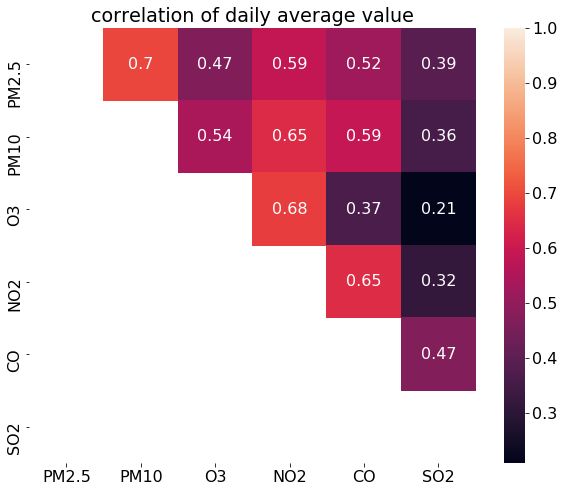

In [408]:
plt.figure(figsize=(10,8))
temp = aqm2_01.resample('d').max()
mask = np.tril(temp[gas_list].corr())
# use spearman rank correlation 
sns.heatmap(temp[gas_list].corr(method='spearman'), annot=True,mask=mask)
plt.title('correlation of daily average value')

In [409]:
data = aqm2_01.resample('d').max()
data['dayofyear'] = data.index.dayofyear
data['year'] = data.index.year

# add winter day 
winterday = data['dayofyear'] - 274
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 274 + winter_day_max  
data['winter_day'] = winterday
# add season (example winter_2000)
data = add_season(data)

# add month-day 
data['month_day'] = data.index.strftime('%m-%d')

# add maping to word 
df = data[['winter_day', 'month_day']].set_index('winter_day')
df.index = df.index.astype(str)
winter_day_dict = df.to_dict()['month_day']

In [469]:
mean_day = data[['CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5', 'dayofyear', 'year',
       'winter_day']].groupby('dayofyear',as_index=False).mean()
mean_day.winter_day = mean_day.winter_day.astype(int)
mean_day.year = mean_day.year.astype(int)

max_day = data[['CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5', 'dayofyear', 'year',
       'winter_day']].groupby('dayofyear',as_index=False).quantile(0.95)
max_day.winter_day = max_day.winter_day.astype(int)
max_day.year = max_day.year.astype(int)

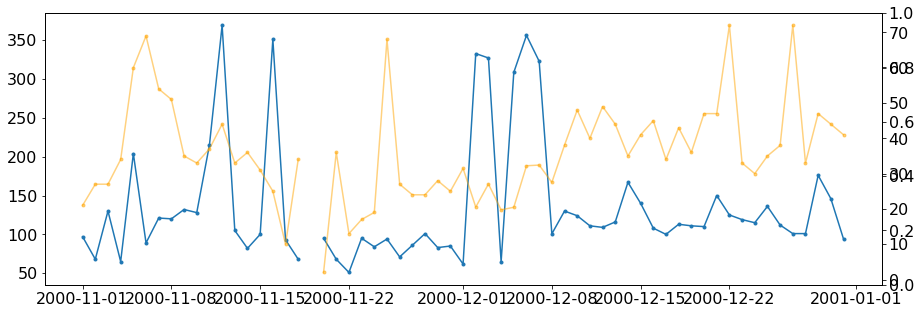

In [308]:
_, ax = plt.subplots(figsize=(15,5))
# select year
df = data[data['year']==year]
ax.plot(df['PM10'],marker='.')
ax1 = ax.twinx()
ax1.plot(df['O3'],marker='.',color='orange',alpha=0.5)
ax1 = ax.twinx()
#ax1.plot(df['CO'],marker='.',color='green',alpha=0.5)

In [366]:
season_list

array(['winter_2000', 'winter_2001', 'winter_2002', 'winter_2003',
       'winter_2004', 'winter_2005', 'winter_2006', 'winter_2007',
       'winter_2008', 'winter_2009', 'winter_2010', 'winter_2011',
       'winter_2012', 'winter_2013', 'winter_2014', 'winter_2015',
       'winter_2016', 'winter_2017', 'winter_2018', 'winter_2019'],
      dtype=object)

c:\users\benny\pyenv\geo\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


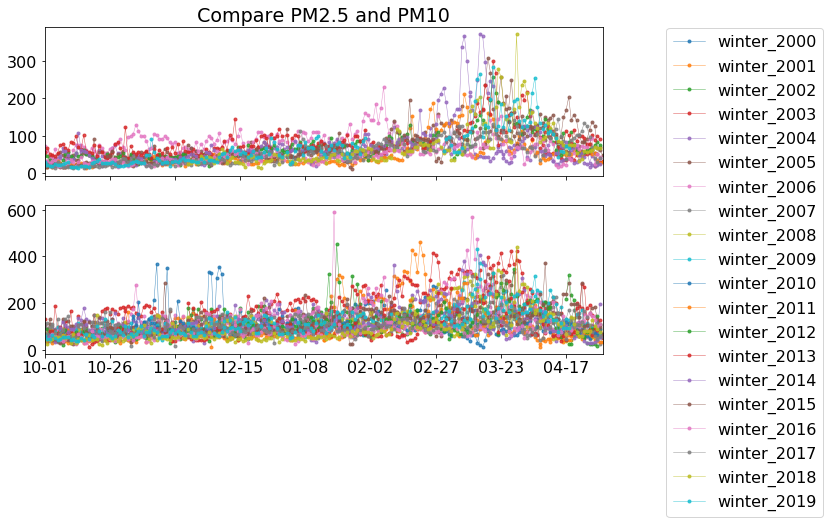

In [417]:
season_list = data['season'].unique() 
season_list = season_list[season_list != 'other']

_, ax = plt.subplots(2, 1, figsize=(10,3*2),sharex=True)

max_tick = 0

for i, (a,gas) in enumerate(zip(ax,gas_list)):
    for season in season_list: 
        temp = data[data['season'] == season]
        if i>=2:
            color='orange'
        else:
            color='royalblue'
        a.plot(temp['winter_day'],temp[gas],marker='.',linewidth=0.5,alpha=0.8,label=season)
        #a.set_title(gas)
       
        
        if max_tick < temp['winter_day'].max():
            max_tick = temp['winter_day'].max()
        if i==0:
            a.set_title('Compare PM2.5 and PM10')
            a.legend( bbox_to_anchor=(1.1, 1.05))
            
ax[-1].set_xlim(min_tick, max_tick)
new_ticks = ['10-01', '10-26', '11-20', '12-15', '01-08', '02-02', '02-27', '03-23', '04-17', '05-13']
# set a new ticklabel
ax[-1].set_xticklabels(new_ticks);
plt.tight_layout()

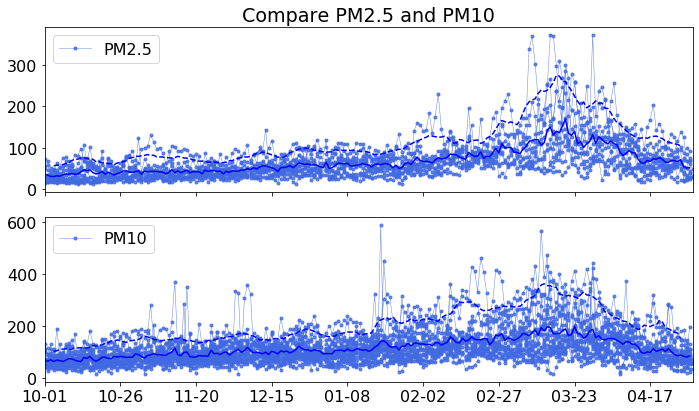

In [470]:
season_list = data['season'].unique() 
season_list = season_list[season_list != 'other']

_, ax = plt.subplots(2, 1, figsize=(10,3*2),sharex=True)

max_tick = 0

for i, (a,gas) in enumerate(zip(ax,gas_list)):
    for season in season_list: 
        temp = data[data['season'] == season]
        if i>=2:
            color='orange'
        else:
            color='royalblue'
        a.plot(temp['winter_day'],temp[gas],marker='.',linewidth=0.5,alpha=0.8,color=color,label=gas)
        #a.set_title(gas)
        
        
        if max_tick < temp['winter_day'].max():
            max_tick = temp['winter_day'].max()
        if i==0:
            a.set_title('Compare PM2.5 and PM10')
            
    temp = mean_day[mean_day['winter_day'] < max_tick]
    temp = temp.sort_values('winter_day')
    a.plot(temp['winter_day'], temp[gas],color='blue',label='mean')
    
    temp = max_day[max_day['winter_day'] < max_tick]
    temp = temp.sort_values('winter_day').rolling(7).mean()
    a.plot(temp['winter_day'], temp[gas],color='blue',label='max',linestyle='dashed')
    
    a.legend([gas],loc='upper left')
            
ax[-1].set_xlim(min_tick, max_tick)
new_ticks = ['10-01', '10-26', '11-20', '12-15', '01-08', '02-02', '02-27', '03-23', '04-17', '05-13']
# set a new ticklabel
ax[-1].set_xticklabels(new_ticks);
plt.tight_layout()

In [359]:
# set a new ticklabel
#ticks = ax[-1].get_xticklabels(minor=False) 
new_ticks = []
for num in np.arange(0,10)*25:
    new_ticks.append(winter_day_dict[str(num)])
     
print(new_ticks)

['10-01', '10-26', '11-20', '12-15', '01-08', '02-02', '02-27', '03-23', '04-17', '05-13']


Daily max of the two gas suggest strong correlation. 

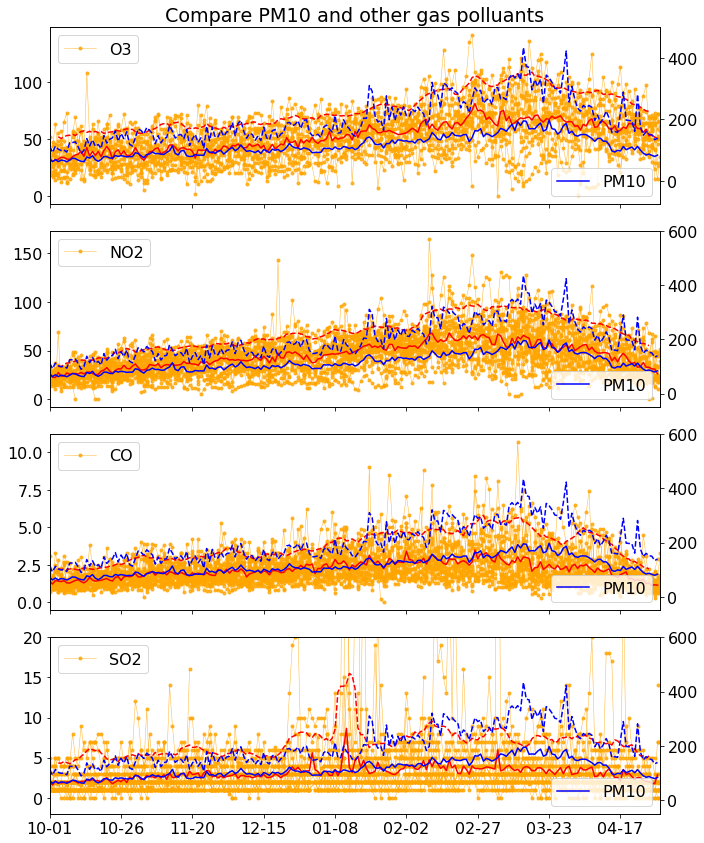

In [464]:
season_list = data['season'].unique() 
season_list = season_list[season_list != 'other']

_, ax = plt.subplots(4, 1, figsize=(10,3*4),sharex=True)

max_tick = 0

for i, (a,gas) in enumerate(zip(ax,gas_list[2:])):
    a1 = a.twinx()
    for season in season_list: 
        temp = data[data['season'] == season].dropna(how='all')
        color='orange'
        
        a.plot(temp['winter_day'],temp[gas],marker='.',linewidth=0.5,alpha=0.8,color=color,label=gas)
        #a.set_title(gas)
        a.legend([gas],loc='upper left')
        
        #a1.plot(temp['winter_day'],temp['PM10'],marker='.',linewidth=0.1,alpha=0.4,color='royalblue',label='PM10')  
        
        if max_tick < temp['winter_day'].max():
            max_tick = temp['winter_day'].max()
        if i==0:
            a.set_title('Compare PM10 and other gas polluants')
            
    temp = mean_day[mean_day['winter_day'] < max_tick]
    temp = temp.sort_values('winter_day')
    a1.plot(temp['winter_day'], temp['PM10'],color='blue',label='mean')
    
    temp = max_day[max_day['winter_day'] < max_tick]
    temp = temp.sort_values('winter_day')
    a1.plot(temp['winter_day'], temp['PM10'],color='blue',label='mean',linestyle='dashed')
    
    
    a1.legend(['PM10'],loc='lower right')
    
            
    temp = mean_day[mean_day['winter_day'] < max_tick]
    temp = temp.sort_values('winter_day')
    a.plot(temp['winter_day'], temp[gas],color='red',label='mean')
    
    temp = max_day[max_day['winter_day'] < max_tick]
    temp = temp.sort_values('winter_day').rolling(7).mean()
    a.plot(temp['winter_day'], temp[gas],color='red',label='max',linestyle='dashed')
    

    if i==0:
        a1.set_ylim([-75,500])
    else:
        a1.set_ylim([-50,600])
    if i ==3:
        a.set_ylim([-2,20])

            
ax[-1].set_xlim(min_tick, max_tick)
new_ticks = ['10-01', '10-26', '11-20', '12-15', '01-08', '02-02', '02-27', '03-23', '04-17', '05-13']
# set a new ticklabel
ax[-1].set_xticklabels(new_ticks);
plt.tight_layout()

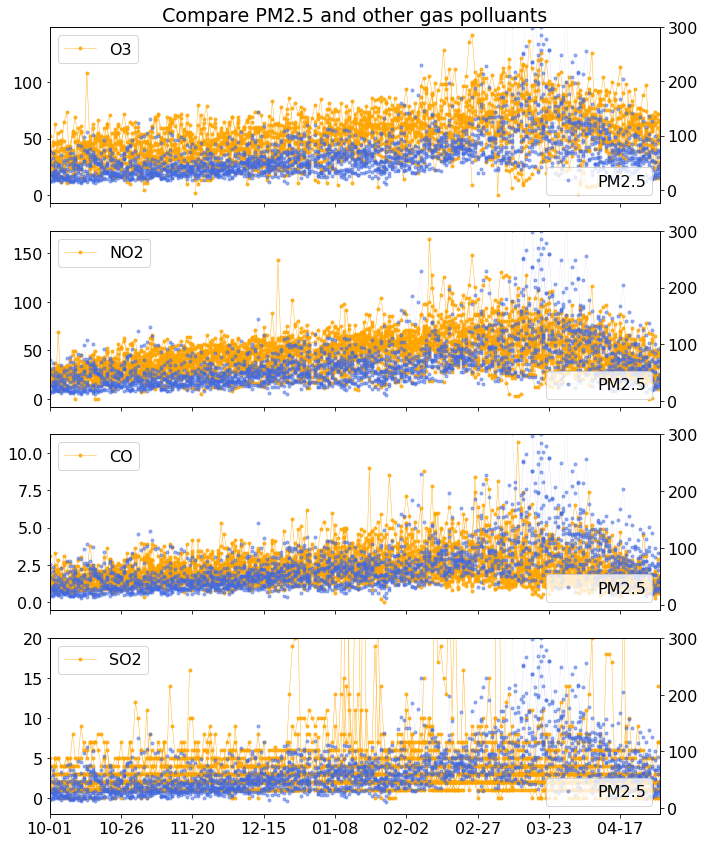

In [400]:
season_list = data['season'].unique() 
season_list = season_list[season_list != 'other']

_, ax = plt.subplots(4, 1, figsize=(10,3*4),sharex=True)

max_tick = 0

for i, (a,gas) in enumerate(zip(ax,gas_list[2:])):
    a1 = a.twinx()
    for season in season_list: 
        temp = data[data['season'] == season].dropna(how='all')
        color='orange'
        
        a.plot(temp['winter_day'],temp[gas],marker='.',linewidth=0.5,alpha=0.8,color=color,label=gas)
        #a.set_title(gas)
        a.legend([gas],loc='upper left')
        
        if max_tick < temp['winter_day'].max():
            max_tick = temp['winter_day'].max()
        if i==0:
            a.set_title('Compare PM2.5 and other gas polluants')
            
        a1.plot(temp['winter_day'],temp['PM2.5'],marker='.',linewidth=0.1,alpha=0.5,color='royalblue',label='PM2.5')
        a1.legend(['PM2.5'],loc='lower right')
        if i==0:
            a1.set_ylim([-25,300])
        else:
            a1.set_ylim([-10,300])
        if i ==3:
            a.set_ylim([-2,20])

            
ax[-1].set_xlim(min_tick, max_tick)
new_ticks = ['10-01', '10-26', '11-20', '12-15', '01-08', '02-02', '02-27', '03-23', '04-17', '05-13']
# set a new ticklabel
ax[-1].set_xticklabels(new_ticks);
plt.tight_layout()

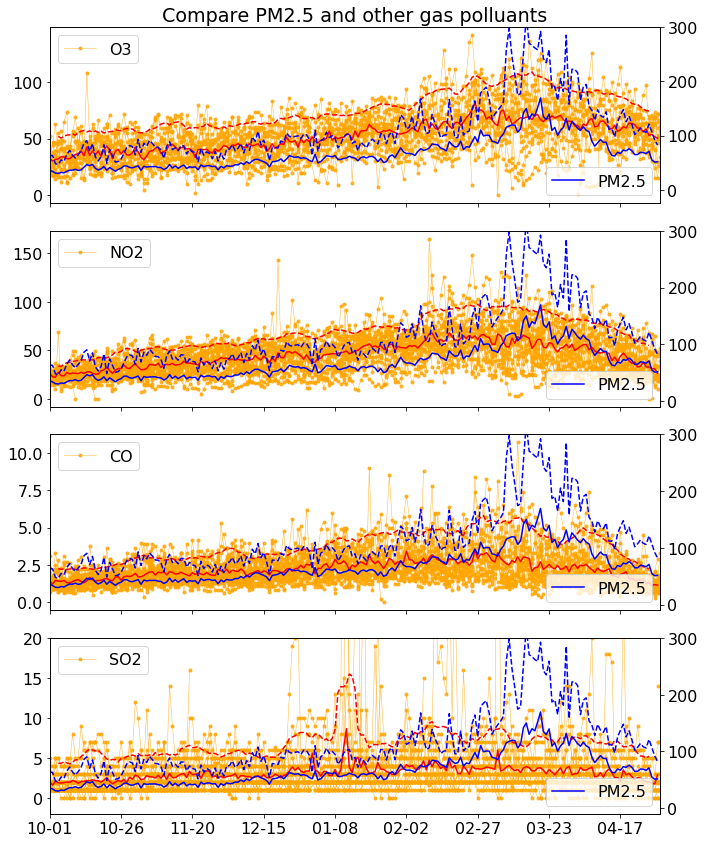

In [465]:
season_list = data['season'].unique() 
season_list = season_list[season_list != 'other']

_, ax = plt.subplots(4, 1, figsize=(10,3*4),sharex=True)

max_tick = 0

for i, (a,gas) in enumerate(zip(ax,gas_list[2:])):
    a1 = a.twinx()
    for season in season_list: 
        temp = data[data['season'] == season].dropna(how='all')
        color='orange'
        
        a.plot(temp['winter_day'],temp[gas],marker='.',linewidth=0.5,alpha=0.8,color=color,label=gas)
        #a.set_title(gas)
        a.legend([gas],loc='upper left')
        
        if max_tick < temp['winter_day'].max():
            max_tick = temp['winter_day'].max()
        if i==0:
            a.set_title('Compare PM2.5 and other gas polluants')
            
        #a1.plot(temp['winter_day'],temp['PM2.5'],marker='.',linewidth=0.1,alpha=0.5,color='royalblue',label='PM2.5')
    
    temp = mean_day[mean_day['winter_day'] < max_tick]
    temp = temp.sort_values('winter_day')
    a1.plot(temp['winter_day'], temp['PM2.5'],color='blue',label='mean')
    
    temp = max_day[max_day['winter_day'] < max_tick]
    temp = temp.sort_values('winter_day')
    a1.plot(temp['winter_day'], temp['PM2.5'],color='blue',label='mean',linestyle='dashed')
    
    temp = mean_day[mean_day['winter_day'] < max_tick]
    temp = temp.sort_values('winter_day')
    a.plot(temp['winter_day'], temp[gas],color='red',label='mean')
    
    temp = max_day[max_day['winter_day'] < max_tick]
    temp = temp.sort_values('winter_day').rolling(7).mean()
    a.plot(temp['winter_day'], temp[gas],color='red',label='max',linestyle='dashed')
    
    
    a1.legend(['PM2.5'],loc='lower right')
    
    if i==0:
        a1.set_ylim([-25,300])
    else:
        a1.set_ylim([-10,300])
    if i ==3:
        a.set_ylim([-2,20])

            
ax[-1].set_xlim(min_tick, max_tick)
new_ticks = ['10-01', '10-26', '11-20', '12-15', '01-08', '02-02', '02-27', '03-23', '04-17', '05-13']
# set a new ticklabel
ax[-1].set_xticklabels(new_ticks);
plt.tight_layout()

The dashed line are percentile 95, and the middle solid line is the mean. 

High Correlation between particle pollutants (PM10 and PM2.5), but moderate correlation with the gas. PM10, is highly correlated with NO2 > CO, O3. Moderate correlation suggest that these are from the same source. The gas normally spike before the particle pollutants. O$_3$ has a longer tail (logger discipation timescale). This can be from the aerodynamic. 

Note that some correlation with SO2 comes from the value around the baseline and is not statically significant.

# Is the pollution getting worse?

- need to look by season 
- the mean tend to underestimate the severity of the situation, while the maximum value is too volatile

In [190]:
data = aqm2_01.copy()
# add season 
data = add_season(data)

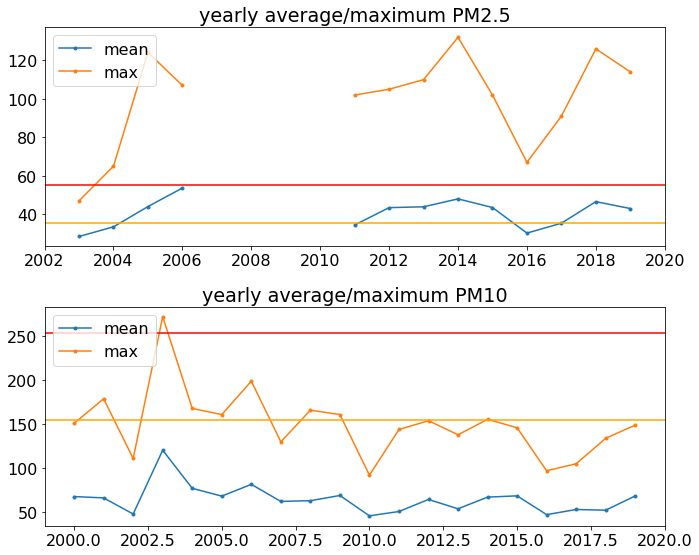

In [531]:
data = aqm2_01.copy()
# add season 
data = add_season(data)

_, ax = plt.subplots(2,1, figsize=(10,8))

temp = data.groupby('season').mean()

temp.drop('other',inplace=True)
index = temp.year.astype(int)
ax[0].plot(index, temp['PM2.5'],marker='.',label='mean')
ax[1].plot(index, temp['PM10'],marker='.',label='mean')


temp = data.groupby('season').quantile(0.95)
temp.year = temp.year.astype(int)
temp.drop('other',inplace=True)
ax[0].plot(index, temp['PM2.5'],marker='.',label='max')
ax[1].plot(index, temp['PM10'],marker='.',label='max')

ax[0].set_xlim([2002, 2020])
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[0].axhline(transition_dict['PM2.5'][1],color='orange')
ax[0].axhline(transition_dict['PM2.5'][2],color='red')
ax[1].axhline(transition_dict['PM10'][1],color='orange')
ax[1].axhline(transition_dict['PM10'][2],color='red')
ax[0].set_title('yearly average/maximum PM2.5')
ax[1].set_title('yearly average/maximum PM10')


ax[1].set_xlim([1999, 2020])

plt.tight_layout()

Text(0.5, 1.0, 'number of bad air days')

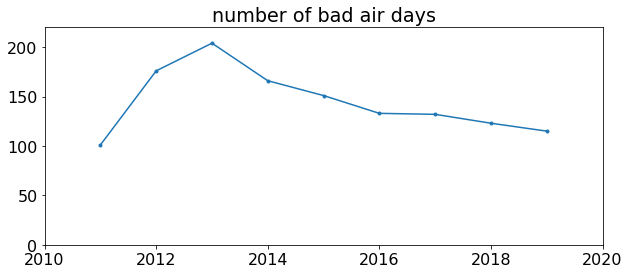

In [538]:
data = aqm2_01.resample('d').max()
for gas in gas_list:
    data[gas] = data[gas] > transition_dict[gas][1]
    
data = add_season(data)
data = data.groupby('season').sum()
data.year = data.index.values
data.year = data.year.str.split('_',expand=True)[1] 


gas = gas_list[0]

_, ax = plt.subplots(1,1, figsize=(10,4))

data.drop('other',inplace=True)
data.year = data.year.astype(int)
data = data[data.year >=2011]
ax.plot(data.year, data['PM2.5'],marker='.')

ax.set_xlim([2010, 2020])
ax.set_ylim([0, 220])
ax.set_title('number of bad air days')

PM10


Text(0.5, 0, 'year')

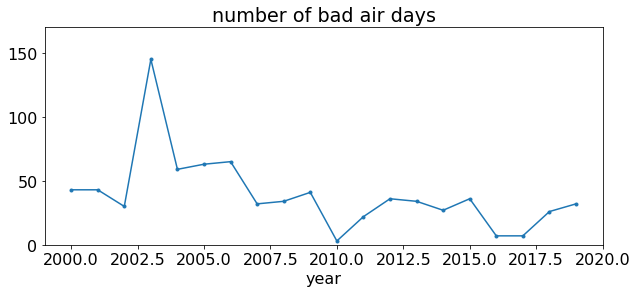

In [256]:
data = aqm2_01.resample('d').max()
for gas in gas_list:
    data[gas] = data[gas] > transition_dict[gas][1]
    
data = add_season(data)
data = data.groupby('season').sum()
data = data.drop('other' )
data.year = data.index.values
data.year = data.year.str.split('_',expand=True)[1] 


gas = gas_list[1]
print(gas)

_, ax = plt.subplots(1,1, figsize=(10,4))


data.year = data.year.astype(int)
ax.plot(data.year, data[gas],marker='.')

ax.set_xlim([1999, 2020])
ax.set_ylim([0, 170])
ax.set_title('number of bad air days')
ax.set_xlabel('year')

# Compare Weather

In [258]:
# berekely data
b_data, city_info = read_b_data(b_folder+'Chiang_Mai.txt')
b_data = b_data.set_index('datetime')
aqm1 = pd.read_csv(cm_folder + '35t.csv').set_index('datetime').dropna(how='all')
aqm1.index = pd.to_datetime(aqm1.index)
aqm2 = pd.read_csv(cm_folder + '36t.csv').set_index('datetime').dropna(how='all')
aqm2.index = pd.to_datetime(aqm2.index)
print(aqm2.columns)
# keep only the data after the satallite data which is 200-11-11 13 am
aqm2_01 = aqm2[aqm2.index>='2000-11-01 00:00:00'].copy()
aqm2_01 = add_season(aqm2_01)
print(aqm2_01.shape)

# weather data 
filename = 'C:/Users/Benny/Documents/Fern/aqi_thailand2/data/weather_cities/chiang-mai.csv'
wea = pd.read_csv(filename)
wea['datetime'] = pd.to_datetime(wea['datetime'])
# merge with weather 

aqm2_01 = aqm2_01.merge(wea, left_index=True, right_on ='datetime',how='inner').set_index('datetime')
print(aqm2_01.shape)

Index(['CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5'], dtype='object')
(167323, 8)
(161140, 18)


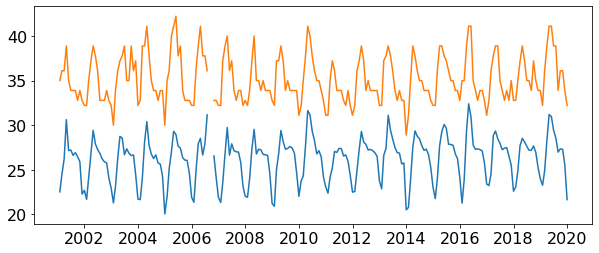

In [262]:
temper = aqm2_01[['Temperature(C)']].copy()



plt.figure(figsize=(10,4))
plt.plot(temper.resample('m').mean() )
plt.plot(temper.resample('m').max() )

Text(0.5, 1.0, 'Avg Temperature in Winter (C)')

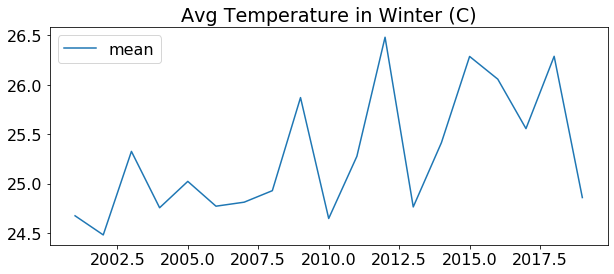

In [312]:

# year avg (only winter ) 
plt.figure(figsize=(10,4))

temper = add_season(temper)
temper.year = temper['season'].str.split('_',expand=True)[1] 
df = temper.groupby('year').mean()
df.index = df.index.astype(int)
plt.plot(df['Temperature(C)'], label='mean')

temper = add_season(temper)
temper.year = temper['season'].str.split('_',expand=True)[1].astype(float)

years = temper.year.dropna().unique() 
q_tile = []
for year in years:
    
    df = temper[temper.year==year]
    q_tile.append(df['Temperature(C)'].quantile(0.90))

#plt.plot(years, q_tile, label='max')

plt.legend()
plt.title('Avg Temperature in Winter (C)')

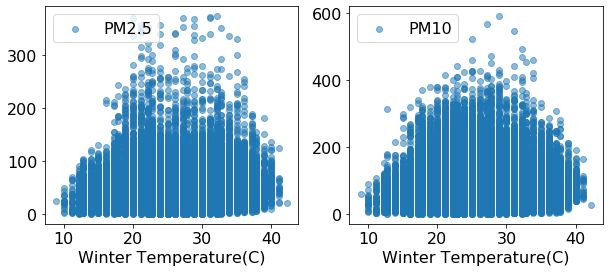

In [327]:
# relastionship with temperature 
aqm2_01 = add_season(aqm2_01)
df = aqm2_01[aqm2_01['season'] != 'other']

_, ax  = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(df['Temperature(C)'], df['PM2.5'],alpha=0.5,label='PM2.5')

ax[1].scatter(df['Temperature(C)'], df['PM10'],alpha=0.5,label='PM10')

for a in ax:
    a.legend()
    a.set_xlabel('Winter Temperature(C)')

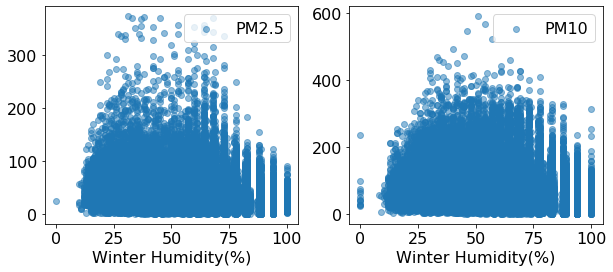

In [328]:
# relastionship with temperature 
aqm2_01 = add_season(aqm2_01)
df = aqm2_01[aqm2_01['season'] != 'other']

_, ax  = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(df['Humidity(%)'], df['PM2.5'],alpha=0.5,label='PM2.5')

ax[1].scatter(df['Humidity(%)'], df['PM10'],alpha=0.5,label='PM10')

for a in ax:
    a.legend()
    a.set_xlabel('Winter Humidity(%)')

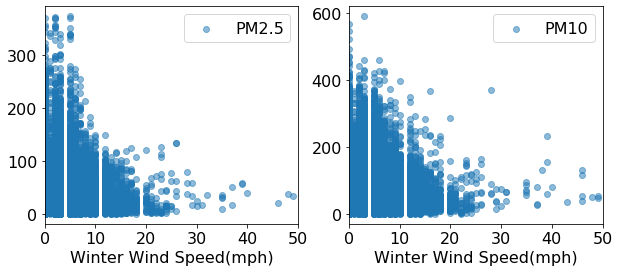

In [333]:
# relastionship with temperature 
aqm2_01 = add_season(aqm2_01)
df = aqm2_01[aqm2_01['season'] != 'other']

_, ax  = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(df['Wind Speed(mph)'], df['PM2.5'],alpha=0.5,label='PM2.5')

ax[1].scatter(df['Wind Speed(mph)'], df['PM10'],alpha=0.5,label='PM10')

for a in ax:
    a.legend()
    a.set_xlabel('Winter Wind Speed(mph)')
    a.set_xlim([0,50])

In [338]:
df['Wind Speed(mph)'].mean()
df['Wind Speed(mph)'].std()

5.683431956342531

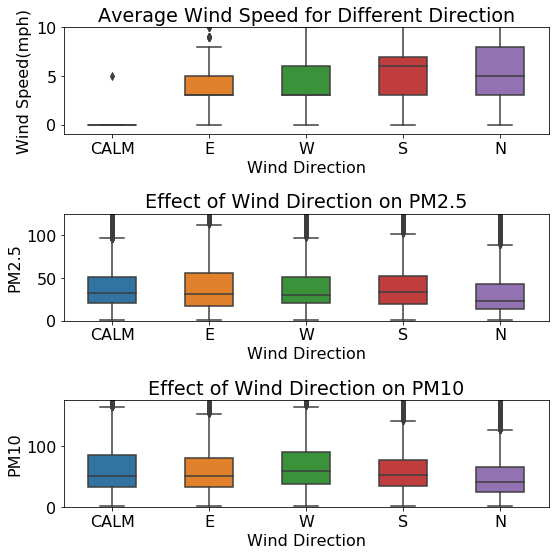

In [412]:
fig, ax = plt.subplots(3,1,figsize=(8,8))


aqm2_01 = add_season(aqm2_01)
wind_data = aqm2_01[aqm2_01['season'] != 'other']
wind_data = wind_data[wind_data['Wind'].isin(['CALM','N','W','E','S'])]
# sort the data by the mean pollution value
wind_sp = wind_data[['Wind Speed(mph)','Wind']].groupby('Wind').agg(['mean','median','std']).dropna()
wind_sp.columns = ['mean','median','std']
wind_sp = wind_sp.sort_values('mean',ascending=True)

sns.boxplot(data=wind_data, x= con, y='Wind Speed(mph)',order=wind_sp.index,width=0.5,ax=ax[0])

ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=0)
ax[0].axes.set_xlabel('Wind Direction')
ax[0].set_title('Average Wind Speed for Different Direction')
ax[0].set_ylim([-1,10])

con ='Wind'

# sort the data by the mean pollution value
pm25_wind = wind_data[['PM2.5','Wind']].groupby('Wind').agg(['mean','median','std']).dropna()
pm25_wind.columns = ['mean','median','std']


#sns.catplot(data=wind_data, x= con, y='PM2.5',alpha=0.1,order=pm25_wind.index, ax=ax[1]) 
sns.boxplot(data=wind_data, x= con, y='PM2.5',order=wind_sp.index,width=0.5,ax=ax[1])

ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=0)
ax[1].axes.set_xlabel('Wind Direction')
ax[1].set_title('Effect of Wind Direction on PM2.5')
ax[1].set_ylim([0,125])


# sort the data by the mean pollution value
pm10_wind = wind_data[['PM10','Wind']].groupby('Wind').agg(['mean','median','std']).dropna()
pm10_wind.columns = ['mean','median','std']

sns.boxplot(data=wind_data, x= con, y='PM10',order=wind_sp.index,width=0.5,ax=ax[2])

ax[2].set_xticklabels(ax[1].get_xticklabels(),rotation=0)
ax[2].axes.set_xlabel('Wind Direction')
ax[2].set_title('Effect of Wind Direction on PM10')
ax[2].set_ylim([0,175])


plt.close(2)
plt.tight_layout()

In [414]:
# Average wind speed for different direction 
wind_data = aqm2_01[aqm2_01['season'] != 'other']
wind_list = ['CALM','N','W','E','S']
for w in wind_list: 
    df = wind_data[wind_data['Wind']== w]
    print(w,'average speed',df['Wind Speed(mph)'].mean() ,  'average PM2.5', df['PM2.5'].mean())
    print(w,'average speed',df['Wind Speed(mph)'].count() ,  'average PM10', df['PM10'].mean())

CALM average speed 0.0034513762000058005 average PM2.5 40.85784257231762
CALM average speed 34479 average PM10 66.75055109445636
N average speed 6.147046589018303 average PM2.5 33.01700554528651
N average speed 4808 average PM10 52.649254404813064
W average speed 4.277599142550911 average PM2.5 38.87747688243065
W average speed 5598 average PM10 69.06185698650127
E average speed 3.9334277620396603 average PM2.5 41.53316326530612
E average speed 2118 average PM10 64.14540279787747
S average speed 5.730141308821512 average PM2.5 40.22763419483101
S average speed 7289 average PM10 62.99220189891092


In [415]:
34479 / ( 34479  + 4808  + 5598 + 2118  + 7289 )

0.6350659397332941

Wind direction from the north has the most effect in reducing the particle pollution. This is an opposite to BKK, where the south wind has clean air from the ocean. This could be because the average speed is higher, however, when comparing the particle pollution between the N and S with similar average wind speed, the south wind does not have clean air effect. Suggestion the high pollution value from the south wind. 

Cannot account for the wind to help because CM situate in a valley. No wind 60% of the time. 

rain day False    0.993266
True     0.006734
Name: is_rain, dtype: float64


(0, 100)

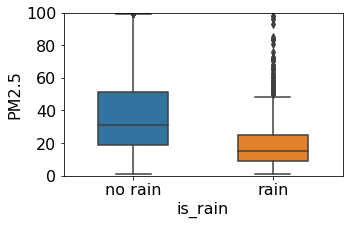

In [446]:
# Effect of rain 
_, ax = plt.subplots(figsize=(5,3))
rain = aqm2_01[aqm2_01['season'] != 'other'].copy()
rain['is_rain'] = rain['Condition'].isin(['Light Rain with Thunder', 'Rain', 'Light Rain',
       'Thunder', 'T-Storm', 'Heavy Rain', 'Rain / Windy',
       'Light Rain / Windy', 'Heavy T-Storm', 'Thunder / Windy',
       'Light Drizzle', 'Drizzle', 'T-Storm / Windy', 
       'Mist', 'Thunder in the Vicinity', 'Showers in the Vicinity', 'Heavy T-Storm / Windy'])
print( 'rain day', rain['is_rain'].value_counts()/len(rain))
pm25_rain = rain[['PM2.5','is_rain']].groupby('is_rain').agg(['mean','median','std']).dropna()
pm25_rain.columns = ['mean','median','std']
pm25_rain = pm25_rain.sort_values('mean',ascending=False)

sns.boxplot(data=rain, x= 'is_rain', y='PM2.5',order=pm25_rain.index,width=0.5,ax = ax)

ax.set_xticklabels(['no rain', 'rain'],rotation=0)
ax.set_ylim([0,100])

Rain drastically reduce the particle pollution, but there are very scared in winter (0.6% of the time). 

# Effect of Logistic Activities

# Seasonal Hotspot